In [1]:
import geopandas as gpd

import pandas as pd
import numpy as np

import os
from collections.abc import Iterable

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint
from shapely.geometry import Polygon

%matplotlib inline

In [3]:
from tqdm.notebook import tqdm

In [4]:
# районы СЗАО

SZAO = ['Куркино', 'Митино', 'Покровское-Стрешнево', 'Северное Тушино', 
 'Южное Тушино', 'Строгино', 'Щукино', 'Хорошево-Мневники']

SUFF_NAMES = pd.DataFrame(SZAO, columns=['adm_name'])

# Путь к графам дорожной сети
GRAPH_PATH = 'processed_data/{}.graphml'

# Путь к наборам данных с изохронами
ISO_PATH = 'processed_data/{}.shp'

# Время в пути
TRAVEL_SPEED = 4.5 # km per hour
METERS_PER_MINUTE = TRAVEL_SPEED * 1000 / 60  # km per hour to m per minute

# Время в пути ограничим 20 минутами
TRIP_TIMES = [20]  # in minutes

In [5]:
def flatten(xs):
    """Flatten nested list."""
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

            
def flatten_coordinates(coord_dict):
    """Flatten coordinates list (for one of data sources)."""
    flat = list(flatten(coord_dict['coordinates']))
    return [(flat[n], flat[n+1]) for n in range(0, len(flat) - 1, 2)]

In [6]:
def download_graph(poly, name):
    """Download walking road network for some polygonal structure and save it to file."""
    filepath = GRAPH_PATH.format(name)
    
    G = ox.graph_from_polygon(poly, network_type='walk')
    ox.save_graphml(G, filepath)

    
def load_graph_file(name):
    """Load network from saved file."""
    filepath = GRAPH_PATH.format(name)
    
    G = ox.load_graphml(filepath)
    return G

In [7]:
def save_isochrones_df(graph_dict, centroids, cell_ids):
    """Compute isochrones and save if in shapefile."""
    nearest_nodes = [ox.distance.nearest_nodes(graph_dict[district], x, y) for x,y in tqdm(centroids)]

    isochrones_data = []

    for n, node in enumerate(tqdm(nearest_nodes)):
        isochrone_polys = make_iso_polys(G, node, edge_buff=25, node_buff=0, infill=True)
        isochrones_data.append([cell_ids[n], isochrone_polys[0]])

    isochrones_df = gpd.GeoDataFrame(pd.DataFrame(isochrones_data, columns=['cell_zid', 'geometry']))

    isochrones_df.to_file(ISO_PATH.format(district))
    

def load_iso_file(name):
    """Load isocrones geodataframe from saved file."""
    filepath = ISO_PATH.format(name)

    df = gpd.read_file(filepath)
    return df

In [8]:
def load_mos_json_data(json_path):
    """Load mos.ru json data as GeoDataFrame."""
    df = pd.read_json(json_path, encoding='cp1251')
    
    try:
        df['geometry'] = [Point(point['coordinates']) if point['type'] == 'Point' 
                      else MultiPoint(point['coordinates']) for point in df['geoData']]
    except:
        df['geometry'] = [Point(point['coordinates']) if point['type'] == 'Point' 
                      else MultiPoint(point['coordinates'][0]) for point in df['geoData']]
    
    df = gpd.GeoDataFrame(df, crs='EPSG: 4326')
    df = df.to_crs('EPSG: 32637')
    
    return df

In [9]:
def make_iso_polys(G, center_node, trip_times=TRIP_TIMES, edge_buff=25, node_buff=50, infill=False):
    """Compute walking trips isochrine polygons."""
    isochrone_polys = []
    
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [10]:
def intersection_score(gdf_dict, merged_df, work_home, adm, merged_name=None, struct_df=SUFF_NAMES):
    """Calculate people, with access to public goods from merged_df dataframe."""
    
    intersected_cells = []
    
    if merged_name is None:
        raise ValueError('Need a name for data column')

    for key in gdf_dict.keys():
        intersected_cells.extend(
            gpd.sjoin(gdf_dict[key], merged_df, how='inner')['cell_zid'].unique().tolist()
        )
        
    merged_suff = (work_home[work_home['zid'].isin(intersected_cells)]
              .merge(
                  adm[adm['adm_name'].isin(SZAO)][['cell_zid', 'adm_name']]
                  .rename(columns={'cell_zid':'zid'})
              )
              .groupby('adm_name')
              .agg(sum_home=('customers_cnt_home', 'sum'))
              .reset_index()
              .rename(columns={'sum_home': merged_name})
             )
    
    merged_suff = struct_df.merge(merged_suff, how='left').fillna(0)
    
    return merged_suff

In [39]:
# https://www.python-graph-gallery.com/390-basic-radar-chart

def plot_radar_chart(df, categories=None):
    """Plot radar chart for scores visualisation."""
    # number of variable
    if categories is None:
        categories=list(df)[1:]
        
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = df.values[0][1:].flatten().tolist()
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='black', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", "1"], color="grey", size=7)
    plt.ylim(0, 1)
    
    plt.title(df.values[0][0], pad=10)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    ax.set_theta_offset(np.pi / 2)
    
    ax.tick_params(
        axis='both',
        pad=15)

    # Show the graph
    plt.show()

# Скачиваем и распаковываем набор данных

Набор уже содержит изначальные и дополнительно собранные данные. Данные размещены на Google Drive.

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=164NLk2O8jgEuC4BAe_fnqj-bJS6D9Bvy

In [ ]:
import zipfile

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [12]:
!ls

 cache			     hackaton_zones.rar
 central_fed_district_data   input_data
 city_data		     processed_data
'hackatonsept2022 (1)'	     self_sufficiency_estimation.ipynb
 hackaton_zones


# Общая идея решения

Возьмем в качестве концепции идею т.н. 20-минутного города. То есть, будем считать, что для каждого места жительства, большая часть потребностей **должна удовлетворяться в рамках 20 минут пешком**.

Из этого предположения и будем исходить при анализе.

Получим следующий процесс оценки:
- Для каждой зоны 500*500 м, получим ее центр и найдем ближайшую вершину пешеходного графа дорог;
- От вершины графа отложим 20-минутную изохрону (полигон, в рамках которого в любую точку можно дойти менее чем за 20 минут);
- Для каждой зоны внутри района получим пересечение между изохроной и важными точками (полигонами) для каждого направления (экономика, медицина и т.д.);
- Будем считать наличие в пешей доступности объектов какого-либо направления за количество ее жителей, а отсутствие за 0, после чего, просуммируем по всем зонам. Тогда можно получить коэффициент число жителей с пешей доступностью направления / все жители района;
- Для оценки достаточности числа рабочих мест, используем коэффициент суммарное число работающих человек / суммарное число жителей во всех зонах района (на основании данных исходного набора данных);
- Полученные показатели приведем к значениям в промежутке [0, 1]. Посчитаем среднее и разброс ряда показателей. 

На основе указанных результатов можно оценить, какие потребности для каких районов удовлетворены лучше или хуже. Дополнительно, можно использовать графические материалы (в конце ноутбука), чтобы исследовать дополнительные показатели и визуализировать положение по каждой из интересующих сфер.

# Исходные данные

Берем следующие данные:
- Географию зон
- Количество живущих и работающих в районе
- Принадлежность зон к административным районам в изначальных данных

In [13]:
zones = gpd.read_file('hackaton_zones/fishnet2021.shp')

work_home = pd.read_csv('hackatonsept2022 (1)/01_Clocation_202109.csv.gz')

adm = pd.read_csv('hackaton_zones/adm2fishnet.csv', sep=';')

In [14]:
# выберем только СЗАО г. Москвы
filtered_zones = (zones
                  .merge(
                      adm[adm['adm_name'].isin(SZAO)][['cell_zid', 'adm_name']]
                  ))

## Далее идет загрузка пешеходных графов и зон доступности

Если нужно получить данные заново, то можно очистить данные в папке processed_data. Предобработанные в рамках погдготовки данные скачиваются с остальными данными в самом начале ноутбука.

In [15]:
graph_dict = {}

for district in SZAO:
    if os.path.isfile(GRAPH_PATH.format(district)):
        graph_dict[district] = load_graph_file(district)
        print(f'Load {district} district from saved files!')
    else:
        download_graph(filtered_zones[filtered_zones['adm_name']==district].unary_union, district)
        print(f'Saved {district} district!')

Load Куркино district from saved files!
Load Митино district from saved files!
Load Покровское-Стрешнево district from saved files!
Load Северное Тушино district from saved files!
Load Южное Тушино district from saved files!
Load Строгино district from saved files!
Load Щукино district from saved files!
Load Хорошево-Мневники district from saved files!


In [16]:
gdf_dict = {}

for district in SZAO:
    if os.path.isfile(ISO_PATH.format(district)):
        gdf_dict[district] = load_iso_file(district)
        print(f'Load {district} district from saved files!')
    else:
        centroids = list(
            zip(
                filtered_zones[filtered_zones['adm_name']==district]['geometry'].centroid.x, 
                filtered_zones[filtered_zones['adm_name']==district]['geometry'].centroid.y
            ))

        G = ox.project_graph(graph_dict[district])

        for _, _, _, data in G.edges(data=True, keys=True):
            data["time"] = data["length"] / METERS_PER_MINUTE

        cell_ids = filtered_zones[filtered_zones['adm_name']==district]['cell_zid'].values
        
        save_isochrones_df(graph_dict, centroids, cell_ids)
        print(f'Saved {district} district!')

Load Куркино district from saved files!
Load Митино district from saved files!
Load Покровское-Стрешнево district from saved files!
Load Северное Тушино district from saved files!
Load Южное Тушино district from saved files!
Load Строгино district from saved files!
Load Щукино district from saved files!
Load Хорошево-Мневники district from saved files!


In [17]:
# укажем систему координат для полигонов доступности
for key in gdf_dict.keys():
    gdf_dict[key].crs = 'EPSG:32637'

# Наборы данных с mos.ru 

Наборы:
- Школы и детские сады
- Взрослые и детские поликлиники
- Остановки НГПТ

In [18]:
schools = pd.read_json('city_data/schools.json', encoding='cp1251')

schools['geometry'] = [MultiPoint(flatten_coordinates(coord_dict)) for coord_dict in tqdm(schools['geoData'])]

schools = gpd.GeoDataFrame(schools, crs='EPSG: 4326')
schools = schools.to_crs('EPSG: 32637')

  0%|          | 0/1064 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [19]:
children_polyclinic = load_mos_json_data('city_data/children_polyclinic.json')

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [20]:
adult_polyclinic = gpd.read_file('city_data/adult_polyclinic.json')
adult_polyclinic = adult_polyclinic.to_crs('EPSG: 32637')

In [21]:
stops = load_mos_json_data('city_data/stops.json')

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


# Набор данных о станцияъ метро, МЦК, МЦД

С портала hh.ru

In [22]:
# https://api.hh.ru/metro/1
metro = pd.read_json('city_data/metro.json', encoding='cp1251')

station_list = []

for line in tqdm(metro['lines']):
    for station in line['stations']:
        station_list.append([station['name'], station['lat'], station['lng']])
        
metro_df = pd.DataFrame(station_list, columns=['name', 'lat', 'lng'])
metro_df['geometry'] = [Point(lon, lat) for lat, lon in metro_df[['lat','lng']].values]
metro_df = gpd.GeoDataFrame(metro_df, crs='EPSG: 4326')


metro_df = metro_df.to_crs('EPSG: 32637')

  0%|          | 0/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


# Данные OSM

Наборы данных:
- природные объекты
- точки притяжения (point of interest)

In [23]:
nature = gpd.read_file('central_fed_district_data/gis_osm_landuse_a_free_1.shp')

In [24]:
poi = gpd.read_file('central_fed_district_data/gis_osm_pois_free_1.shp')

In [25]:
recreation = nature[nature['fclass'].isin(['park', 'nature_reserve', 'recreation_ground'])].copy()
recreation = recreation.to_crs('EPSG: 32637')

cinema = poi[poi['fclass']=='cinema'].copy()
cinema = cinema.to_crs('EPSG: 32637')

library = poi[poi['fclass']=='library'].copy()
library = library.to_crs('EPSG: 32637')

restaurant = poi[poi['fclass']=='restaurant'].copy()
restaurant = restaurant.to_crs('EPSG: 32637')

## Количество жителей с доступом к различным способам отдыха

In [26]:
recreation_suff = intersection_score(gdf_dict, recreation, work_home, adm, 'recreation_sum_home')
cinema_suff = intersection_score(gdf_dict, cinema, work_home, adm, 'cinema_sum_home')
library_suff = intersection_score(gdf_dict, library, work_home, adm, 'library_sum_home')
restaurant_suff = intersection_score(gdf_dict, restaurant, work_home, adm, 'restaurant_sum_home')

rest_suff = recreation_suff[['adm_name']]

rest_suff['rest_sum_home'] = np.mean([recreation_suff['recreation_sum_home'], cinema_suff['cinema_sum_home'], 
                                      library_suff['library_sum_home'], restaurant_suff['restaurant_sum_home']], 
                                     axis=0)

recreation_suff.merge(cinema_suff).merge(library_suff).merge(restaurant_suff)

,adm_name,recreation_sum_home,cinema_sum_home,library_sum_home,restaurant_sum_home
0,Куркино,34902,0.0,0.0,30586
1,Митино,109950,65902.0,79584.0,106253
2,Покровское-Стрешнево,58534,6305.0,30561.0,43729
3,Северное Тушино,99639,43864.0,97771.0,83728
4,Южное Тушино,75841,33511.0,64961.0,60992
5,Строгино,74393,3519.0,70351.0,67721
6,Щукино,93083,68871.0,84140.0,92443
7,Хорошево-Мневники,137311,14010.0,100711.0,116116


## Количество жителей с доступом к бытовым услугам

In [27]:
bank = poi[poi['fclass']=='bank'].copy()
bank = bank.to_crs('EPSG: 32637')

supermarket = poi[poi['fclass']=='supermarket'].copy()
supermarket = supermarket.to_crs('EPSG: 32637')

pharmacy = poi[poi['fclass']=='pharmacy'].copy()
pharmacy = pharmacy.to_crs('EPSG: 32637')

bank_suff = intersection_score(gdf_dict, bank, work_home, adm, 'bank_sum_home')
supermarket_suff = intersection_score(gdf_dict, supermarket, work_home, adm, 'supermarket_sum_home')
pharmacy_suff = intersection_score(gdf_dict, pharmacy, work_home, adm, 'pharmacy_sum_home')

domestic_suff = pharmacy_suff[['adm_name']]

domestic_suff['domestic_sum_home'] = np.mean([bank_suff['bank_sum_home'], 
        supermarket_suff['supermarket_sum_home'], pharmacy_suff['pharmacy_sum_home']], axis=0)

bank_suff.merge(supermarket_suff).merge(pharmacy_suff)

,adm_name,bank_sum_home,supermarket_sum_home,pharmacy_sum_home
0,Куркино,30565,33883,33624
1,Митино,106296,110355,109287
2,Покровское-Стрешнево,54762,56101,55622
3,Северное Тушино,99192,99354,99354
4,Южное Тушино,75841,75841,75362
5,Строгино,74205,74392,73941
6,Щукино,84628,93153,93153
7,Хорошево-Мневники,121906,130113,135814


## Количество жителей с доступом к школам

In [28]:
schools_suff = intersection_score(gdf_dict, schools, work_home, adm, 'schools_sum_home')
schools_suff

,adm_name,schools_sum_home
0,Куркино,32364
1,Митино,107577
2,Покровское-Стрешнево,56609
3,Северное Тушино,99354
4,Южное Тушино,75841
5,Строгино,76041
6,Щукино,93153
7,Хорошево-Мневники,131736


## Количество жителей с доступом к поликлиникам

In [29]:
children_poly_suff = intersection_score(gdf_dict, children_polyclinic, work_home, adm, 'children_poly_sum_home')
adult_poly_suff = intersection_score(gdf_dict, adult_polyclinic, work_home, adm, 'adult_poly_sum_home')

medicine_suff = children_poly_suff[['adm_name']]
medicine_suff['medicine_sum_home'] = np.mean([children_poly_suff['children_poly_sum_home'], 
        adult_poly_suff['adult_poly_sum_home']], axis=0)

children_poly_suff.merge(adult_poly_suff)

,adm_name,children_poly_sum_home,adult_poly_sum_home
0,Куркино,16530,16530
1,Митино,80792,87894
2,Покровское-Стрешнево,30511,44028
3,Северное Тушино,90684,91459
4,Южное Тушино,46420,44491
5,Строгино,58067,62452
6,Щукино,48648,74409
7,Хорошево-Мневники,88572,89032


## Количество жителей с доступом к НГПТ, метро, МЦК, МЦД

In [30]:
stops_suff = intersection_score(gdf_dict, stops, work_home, adm, 'stops_sum_home')
metro_suff = intersection_score(gdf_dict, metro_df, work_home, adm, 'metro_sum_home')

transport_suff = stops_suff[['adm_name']]

transport_suff['transport_sum_home'] = np.mean([stops_suff['stops_sum_home'], 
        metro_suff['metro_sum_home']], axis=0)

stops_suff.merge(metro_suff)

,adm_name,stops_sum_home,metro_sum_home
0,Куркино,32433,0.0
1,Митино,110587,94988.0
2,Покровское-Стрешнево,58534,32301.0
3,Северное Тушино,99639,85070.0
4,Южное Тушино,75841,54265.0
5,Строгино,78076,57248.0
6,Щукино,93153,79951.0
7,Хорошево-Мневники,142219,36183.0


## Количество живущих и работающих по районам

In [31]:
work_suff = (work_home
 .merge(
     adm[adm['adm_name'].isin(SZAO)][['cell_zid', 'adm_name']]
     .rename(columns={'cell_zid':'zid'})
 )
 .groupby('adm_name')
 .agg(sum_home=('customers_cnt_home', 'sum'), sum_job=('customers_cnt_job', 'sum'))
 .reset_index()
)

In [32]:
# соединим все ранее полученные цифры
scores_df = work_suff.copy()

for step_df in [medicine_suff, schools_suff, domestic_suff, rest_suff, transport_suff]:
    scores_df = scores_df.merge(step_df)

In [33]:
# преобразуем к доле от всех жителей
scores_df['work_score'] = np.round(scores_df['sum_job'] / scores_df['sum_home'], 2)
scores_df['medicine_score'] = np.round(scores_df['medicine_sum_home'] / scores_df['sum_home'], 2)
scores_df['domestic_score'] = np.round(scores_df['domestic_sum_home'] / scores_df['sum_home'], 2)
scores_df['rest_score'] = np.round(scores_df['rest_sum_home'] / scores_df['sum_home'], 2)
scores_df['transport_score'] = np.round(scores_df['transport_sum_home'] / scores_df['sum_home'], 2)
scores_df['schools_score'] = np.round(scores_df['schools_sum_home'] / scores_df['sum_home'], 2)

# вычислим среднее и среднекв. отклонение
scores_df['mu'] = np.round(scores_df[scores_df.columns[scores_df.columns.str.contains('score')]].mean(axis=1).values, 
                           2)
scores_df['sigma'] = np.round(scores_df[scores_df.columns[scores_df.columns.str.contains('score')]].std(axis=1).values,
                              2)

# Общие результаты по всем районам СЗАО

In [34]:
scores_df[['adm_name', 'work_score', 'medicine_score', 'transport_score', 'schools_score', 
          'domestic_score', 'rest_score', 'mu', 'sigma']].sort_values(['mu'], ascending=False)

,adm_name,work_score,medicine_score,transport_score,schools_score,domestic_score,rest_score,mu,sigma
3,Северное Тушино,0.36,0.91,0.93,1.00,1.00,0.82,0.84,0.24
6,Щукино,0.53,0.66,0.93,1.00,0.97,0.91,0.83,0.19
1,Митино,0.34,0.76,0.93,0.97,0.98,0.82,0.80,0.24
7,Южное Тушино,0.50,0.60,0.86,1.00,1.00,0.78,0.79,0.21
2,Покровское-Стрешнево,0.74,0.64,0.77,0.96,0.95,0.59,0.78,0.15
4,Строгино,0.40,0.77,0.87,0.97,0.95,0.69,0.78,0.21
5,Хорошево-Мневники,0.48,0.62,0.63,0.92,0.91,0.65,0.70,0.18
0,Куркино,0.40,0.47,0.46,0.92,0.93,0.46,0.61,0.25


In [35]:
mu = scores_df[scores_df.columns[scores_df.columns.str.contains('score')]].mean(axis=1).values
sigma = scores_df[scores_df.columns[scores_df.columns.str.contains('score')]].std(axis=1).values

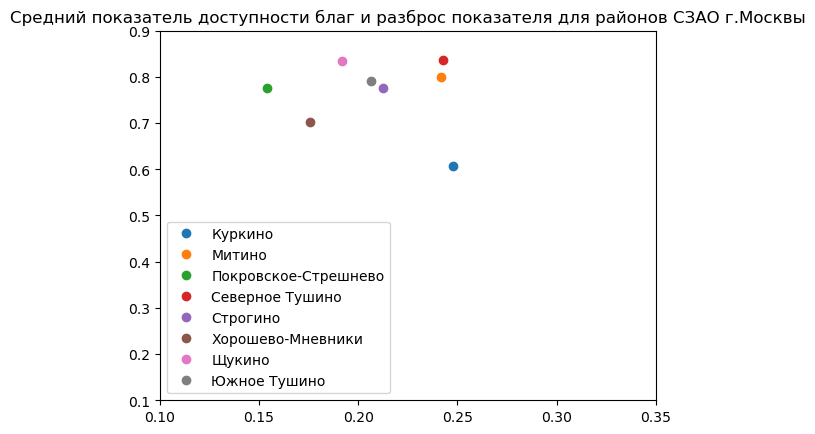

In [37]:
for n, _ in enumerate(mu):
    plt.plot(sigma[n], mu[n], 'o', label=scores_df['adm_name'].values[n])
    
plt.title('Средний показатель доступности благ и разброс показателя для районов СЗАО г.Москвы')

plt.xlim([0.1, 0.35])
plt.ylim([0.1, 0.9])    

plt.legend(loc='best');

# Посмотрим два примера районов 

Выберем следующие районы:
- Хорошево-Мневники
- Митино

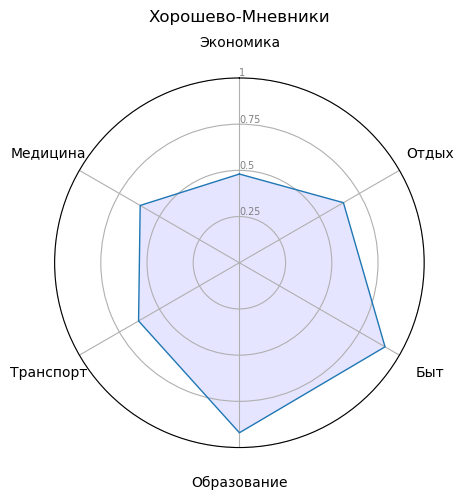

In [43]:
plot_radar_chart(scores_df[scores_df['adm_name']=='Хорошево-Мневники'][
    ['adm_name', 'work_score', 'medicine_score', 'transport_score', 'schools_score', 
          'domestic_score', 'rest_score']], ['Экономика', 'Медицина', 'Транспорт', 'Образование', 'Быт', 'Отдых'])

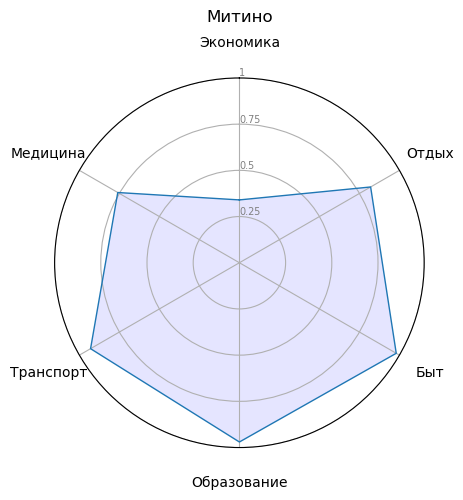

In [44]:
plot_radar_chart(scores_df[scores_df['adm_name']=='Митино'][
    ['adm_name', 'work_score', 'medicine_score', 'transport_score', 'schools_score', 
          'domestic_score', 'rest_score']], ['Экономика', 'Медицина', 'Транспорт', 'Образование', 'Быт', 'Отдых'])

# Дополнительные материалы

Визуализируем зоны имеющие доступ (зеленый цвет) и не имеющие доступа (красный цвет) при ограничении пешеходной доступности в 20 минут для взрослых поликлиник.

В принципе, такие визуализации можно построить для любого района из СЗАО и любого набора данных, чтобы оценить детально доспутность тех или иных благ.

In [40]:
import folium

In [41]:
merged_cells = gpd.sjoin(gdf_dict['Хорошево-Мневники'], adult_polyclinic, how='inner')['cell_zid'].unique().tolist()
all_cells = adm[adm['adm_name']=='Хорошево-Мневники']['cell_zid'].values

centroid = zones[zones['cell_zid'].isin(all_cells)]['geometry'].unary_union.centroid

inter_poly = (gpd.sjoin(adult_polyclinic, gdf_dict['Хорошево-Мневники'], how='inner').
 to_crs('EPSG: 4326')
.unary_union)

m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)

for _, r in zones[zones['cell_zid'].isin(merged_cells)].iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'green'})
    geo_j.add_to(m)
    
for _, r in zones[zones['cell_zid'].isin(set(all_cells) - set(merged_cells))].iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red'})
    geo_j.add_to(m)
    
for point in list(inter_poly):
    folium.Marker((point.y, point.x)).add_to(m)

m

/tmp/ipykernel_1163/3536254178.py:30: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for point in list(inter_poly):
/tmp/ipykernel_1163/3536254178.py:30: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for point in list(inter_poly):


In [42]:
merged_cells = gpd.sjoin(gdf_dict['Митино'], adult_polyclinic, how='inner')['cell_zid'].unique().tolist()
all_cells = adm[adm['adm_name']=='Митино']['cell_zid'].values

centroid = zones[zones['cell_zid'].isin(all_cells)]['geometry'].unary_union.centroid

inter_poly = (gpd.sjoin(adult_polyclinic, gdf_dict['Митино'], how='inner').
 to_crs('EPSG: 4326')
.unary_union)

m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)

for _, r in zones[zones['cell_zid'].isin(merged_cells)].iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'green'})
    geo_j.add_to(m)
    
for _, r in zones[zones['cell_zid'].isin(set(all_cells) - set(merged_cells))].iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red'})
    geo_j.add_to(m)
    
for point in list(inter_poly):
    folium.Marker((point.y, point.x)).add_to(m)

m

/tmp/ipykernel_1163/3849555502.py:30: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for point in list(inter_poly):
/tmp/ipykernel_1163/3849555502.py:30: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for point in list(inter_poly):
